In [127]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, EvenProcess, GoldenMean, Mess3, RIP, TransitionMatrixProcess
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.comp_mech.reversal import reverse_process, get_recurrent_component_process_from_mstree, get_prob_forward_given_past, joint_prob_from_conditional
from epsilon_transformers.comp_mech.reversal import joint_prob_from_conditional
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
from typing import Dict, Tuple
from tqdm.auto import tqdm

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
p = Mess3(x=0.15, a=0.4)
T = p.transition_matrix
T_given_emission = T/T.sum(axis=2, keepdims=True)
steady_state = p.steady_state_vector

for depth in range(9):
    new_vec = np.linalg.matrix_power(T.sum(axis=0), depth) - p.steady_state_vector
    print(np.sqrt(np.sum(np.square(new_vec), axis=1))[0])

0.8164965809277259
0.4490731195102492
0.24699021573063698
0.1358446186518503
0.07471454025851756
0.04109299714218463
0.022601148428201455
0.012430631635510772
0.006836847399530888


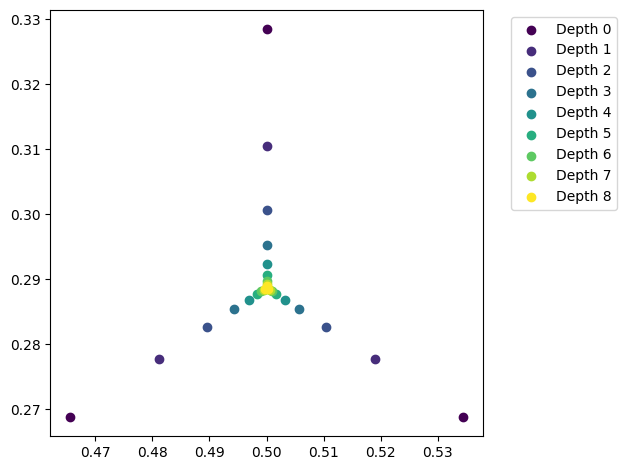

In [3]:
from epsilon_transformers.visualization.plots import _project_to_simplex

# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, 9))

for depth in range(9):
    T_pow = np.linalg.matrix_power(T.sum(axis=0), depth)
    vectors = np.einsum('i,eij->ej', steady_state, T_given_emission)
    final_vector = np.einsum('ej,ji->ei', vectors, T_pow)
    final_vector = np.array(_project_to_simplex(final_vector)).T
    plt.scatter(final_vector[:,0], final_vector[:,1], c=[colors[depth]], label=f'Depth {depth}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


In [4]:
msp = p.derive_mixed_state_tree(9)
paths, beliefs = msp.paths_and_belief_states

In [11]:

p = Mess3(x=0.15, a=0.6)
T = p.transition_matrix
T_given_emission = T/T.sum(axis=2, keepdims=True)
steady_state = p.steady_state_vector

for depth in range(9):
    new_vec = np.linalg.matrix_power(T.sum(axis=0), depth) - p.steady_state_vector
    print(np.sqrt(np.sum(np.square(new_vec), axis=1))[0])

ss = p.steady_state_vector
all_vecs = []

# Pre-compute T_pow matrices for all possible depths
max_depth = max(len(path) for path in paths)
T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
    depth = len(path)
    if depth == 0:
        continue
    
    vec = np.zeros(3)
    for i, x in enumerate(reversed(path)):
        last_symbol_update = np.einsum('i,ij->j', steady_state, T_given_emission[x])
        sequence_depth_update = np.einsum('j,ji->i', last_symbol_update, T_pow_cache[i])
        vec += sequence_depth_update - ss
    
    all_vecs.append(vec)

all_vecs = np.array(all_vecs)  # Convert to numpy array for better performance

0.8164965809277259
0.4490731195102492
0.24699021573063698
0.1358446186518503
0.07471454025851756
0.04109299714218463
0.022601148428201455
0.012430631635510772
0.006836847399530888


Processing Paths:   0%|          | 0/29525 [00:00<?, ?it/s]

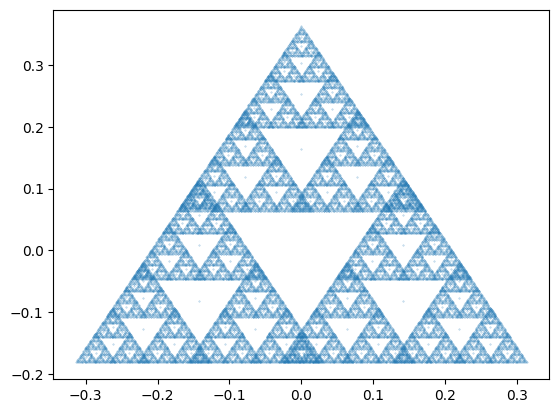

In [12]:
all_vecs_proj = _project_to_simplex(all_vecs)
plt.scatter(all_vecs_proj[0], all_vecs_proj[1], s=.1, alpha=.5)

Processing Paths: 100%|██████████| 29525/29525 [00:01<00:00, 27194.76it/s]


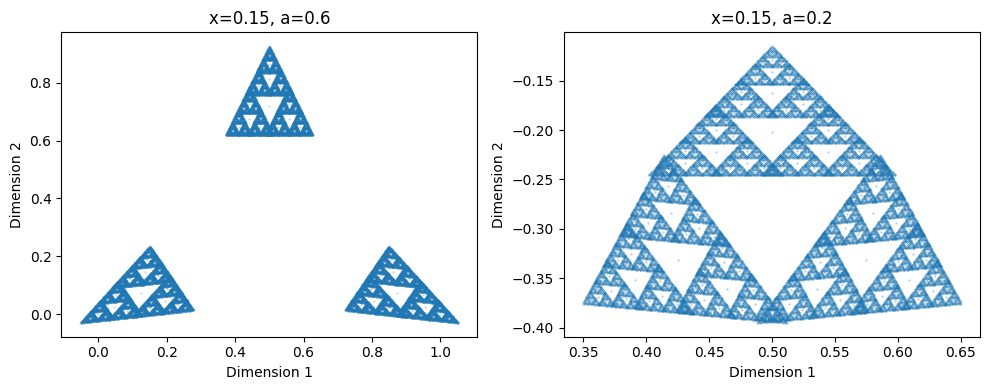

In [122]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_belief_vectors(x, a, depth):
    p = Mess3(x=x, a=a)
    T = p.transition_matrix
    T_given_emission = T / T.sum(axis=2, keepdims=True)
    steady_state = p.steady_state_vector
    ss = steady_state

    msp = p.derive_mixed_state_tree(depth)
    paths, _ = msp.paths_and_belief_states

    # Pre-compute T_pow matrices for all possible depths
    max_depth = max(len(path) for path in paths)
    T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

    all_vecs = []

    for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
        path_depth = len(path)
        if path_depth == 0 or path_depth > depth:
            continue
        
        
        end_symbol = path[-1]
        vec = np.einsum('i,ij->j', ss, T_given_emission[end_symbol])
        for i, x in enumerate(reversed(path[:-1])):

            early_symbol_update = np.einsum('i,ij->j', steady_state, T_given_emission[x])
            sequence_depth_update = np.einsum('j,ji->i', early_symbol_update, T_pow_cache[i])
            last_symbol_update = np.einsum('j,ji->i', sequence_depth_update, T_given_emission[end_symbol])
            vec += last_symbol_update - np.einsum('i,ij->j', ss, T_given_emission[end_symbol])
        
        all_vecs.append(vec)

    return np.array(all_vecs)  # Convert to numpy array for better performance

# Compute belief vectors for x=0.15 and a=0.6
all_vecs_06 = compute_belief_vectors(x=0.15, a=0.9, depth=9)

# Compute belief vectors for x=0.15 and a=0.2
all_vecs_02 = compute_belief_vectors(x=0.15, a=0.2, depth=9)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot for a=0.6
all_vecs_proj_06 = _project_to_simplex(all_vecs_06)
ax1.scatter(all_vecs_proj_06[0], all_vecs_proj_06[1], s=0.1, alpha=0.5)
ax1.set_title('x=0.15, a=0.6')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')

# Plot for a=0.2
all_vecs_proj_02 = _project_to_simplex(all_vecs_02)
ax2.scatter(all_vecs_proj_02[0], -all_vecs_proj_02[1], s=0.1, alpha=0.65)
ax2.set_title('x=0.15, a=0.2')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

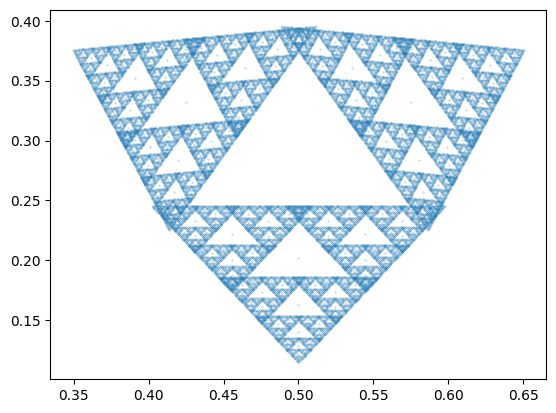

In [43]:
all_vecs_proj = _project_to_simplex(all_vecs)
plt.scatter(all_vecs_proj[0], all_vecs_proj[1], s=.1, alpha=.5)

In [ ]:

for i in range(9):
    belief_conditional_update = np.einsum('i,ij->j', belief_conditional_update, T.sum(axis=0))
    print(belief_conditional_update)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

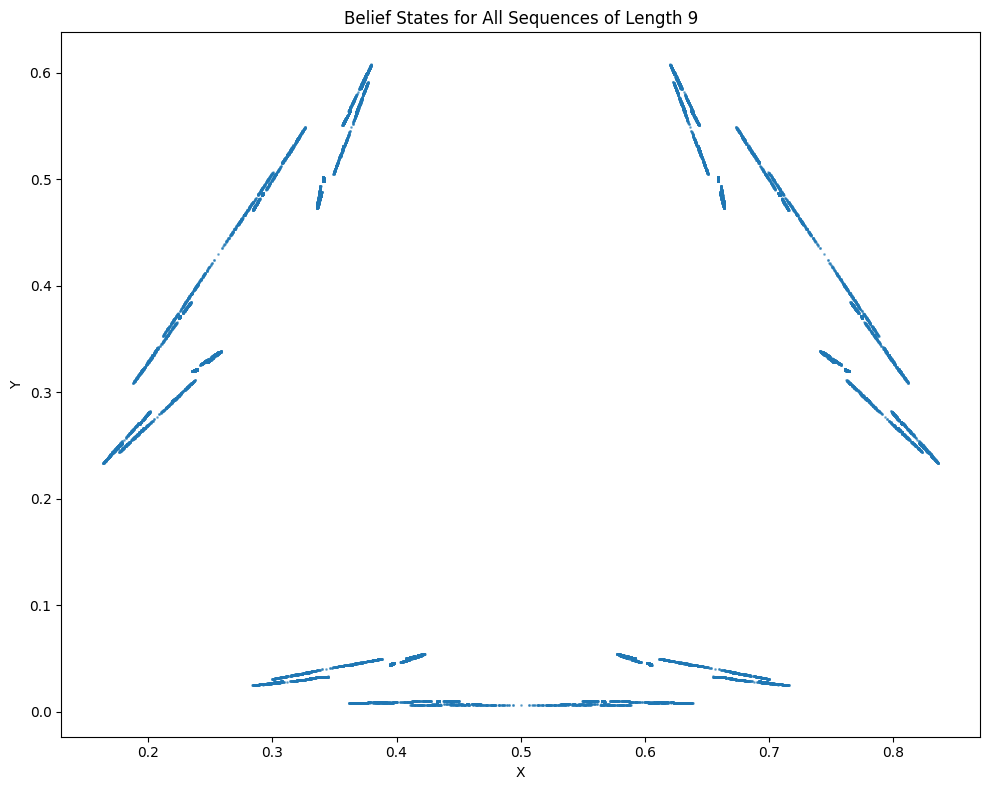

In [ ]:
import itertools
# Initialize an empty list to store all sequences
all_sequences = []

# Generate all possible sequences of length 'depth'
def generate_sequences(depth):
    for sequence in itertools.product(range(3), repeat=depth):
        all_sequences.append(sequence)

# Set the desired depth
depth = 9

# Generate all sequences
generate_sequences(depth)

# Initialize a list to store the final belief states for each sequence
final_belief_states = []

# Iterate over all depths
for depth in range(0, 8):
    T_pow = np.linalg.matrix_power(T.sum(axis=0), depth)
    # and then we see



# Convert to numpy array for easier manipulation
final_belief_states = np.array(final_belief_states)

# Project the belief states onto the 2D simplex
projected_states = np.array(_project_to_simplex(final_belief_states)).T

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(projected_states[:, 0], projected_states[:, 1], alpha=0.5, s=1)
plt.title(f"Belief States for All Sequences of Length {depth}")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


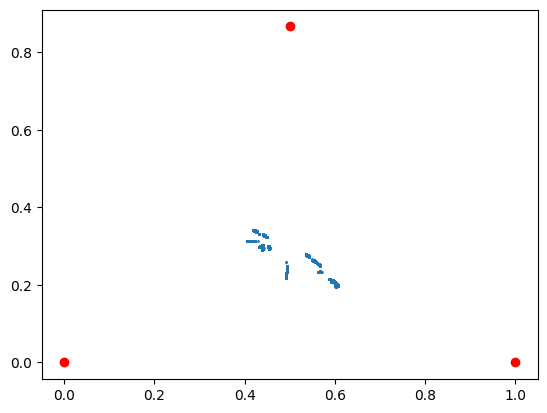

In [ ]:
T = np.random.rand(3,3,3)
T = T/(T.sum(axis=2, keepdims=True).sum(axis=0, keepdims=True))
p = TransitionMatrixProcess(T)
msp = p.derive_mixed_state_tree(10)
paths, beliefs = msp.paths_and_belief_states
beliefs = np.array(beliefs)
beliefs = _project_to_simplex(beliefs)
plt.scatter(beliefs[0], beliefs[1], s=1)


corners = np.array([[1,0,0], [0,1,0], [0,0,1]])
corners = _project_to_simplex(corners)
plt.scatter(corners[0], corners[1], c='red')


In [ ]:
beliefs

(array([0.53858858, 0.53858858, 0.51943181, ..., 0.52581111, 0.57530469,
        0.52145511]),
 array([0.2930577 , 0.2930577 , 0.29474498, ..., 0.3021443 , 0.24315973,
        0.32997371]))

Processing Paths: 100%|██████████| 29525/29525 [00:02<00:00, 13437.36it/s]


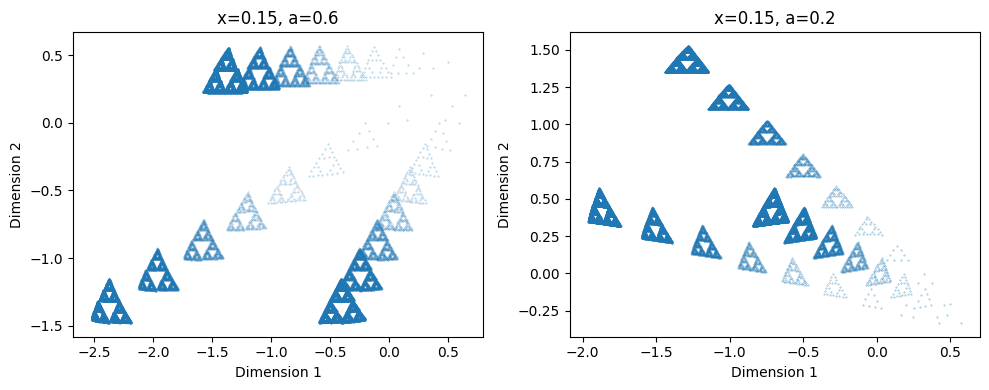

In [96]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_belief_vectors(x, a, depth):
    p = Mess3(x=x, a=a)
    T = p.transition_matrix
    T_given_emission = T / T.sum(axis=2, keepdims=True)
    steady_state = p.steady_state_vector
    ss = steady_state

    msp = p.derive_mixed_state_tree(depth)
    paths, _ = msp.paths_and_belief_states

    # Pre-compute T_pow matrices for all possible depths
    max_depth = max(len(path) for path in paths)
    T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

    all_vecs = []

    for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
        path_depth = len(path)
        if path_depth == 0 or path_depth > depth:
            continue
        
        
        end_symbol = path[-1]
        vecs_per_path = []
        vecs_per_path.append(np.einsum('i,ij->j', ss, T_given_emission[end_symbol]))
        for i, x in enumerate(reversed(path[:-1])):
            early_symbol_update = np.einsum('i,ij->j', steady_state, T_given_emission[x])
            sequence_depth_update = np.einsum('j,ji->i', early_symbol_update, T_pow_cache[i])
            last_symbol_update = np.einsum('j,ji->i', sequence_depth_update, T_given_emission[end_symbol])
            
            # Subtract components in the direction of each vector in vecs_per_path
            for vec in vecs_per_path:
                projection = np.dot(vec, last_symbol_update) * vec
                last_symbol_update = last_symbol_update - projection
            
            vecs_per_path.append(last_symbol_update-ss)
        
        all_vecs.append(np.sum(vecs_per_path, axis=0))

    return np.array(all_vecs)  # Convert to numpy array for better performance

# Compute belief vectors for x=0.15 and a=0.6
all_vecs_06 = compute_belief_vectors(x=0.15, a=0.6, depth=9)

# Compute belief vectors for x=0.15 and a=0.2
all_vecs_02 = compute_belief_vectors(x=0.15, a=0.2, depth=9)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot for a=0.6
all_vecs_proj_06 = _project_to_simplex(all_vecs_06)
ax1.scatter(all_vecs_proj_06[0], all_vecs_proj_06[1], s=0.1, alpha=0.5)
ax1.set_title('x=0.15, a=0.6')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')

# Plot for a=0.2
all_vecs_proj_02 = _project_to_simplex(all_vecs_02)
ax2.scatter(all_vecs_proj_02[0], -all_vecs_proj_02[1], s=0.1, alpha=0.65)
ax2.set_title('x=0.15, a=0.2')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

In [55]:
all_vecs_06.shape

(250959, 3)

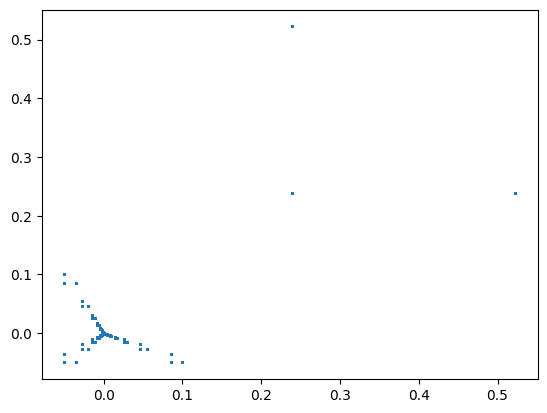

In [58]:
plt.scatter(all_vecs_06[:,0], all_vecs_06[:,1], s=1)

Processing Paths: 100%|██████████| 29525/29525 [00:00<00:00, 57224.99it/s]


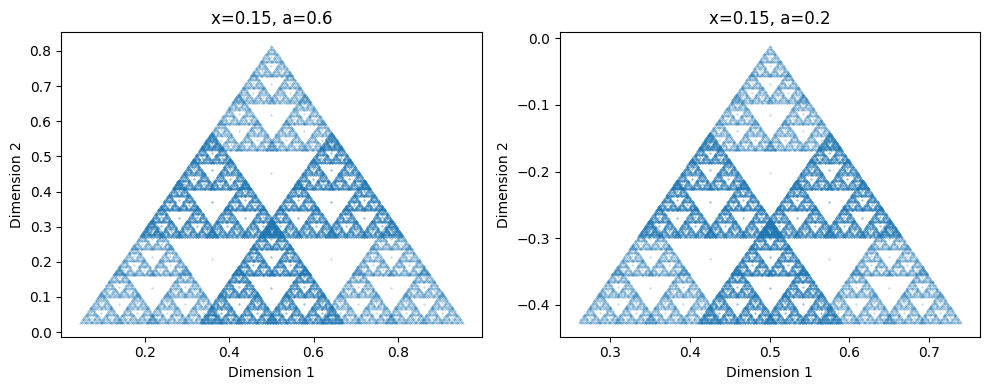

In [157]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def compute_belief_vectors(x, a, depth, type='bigram', offset=0):
    p = Mess3(x=x, a=a)
    T = p.transition_matrix
    T_given_emission = T / T.sum(axis=2, keepdims=True)
    steady_state = p.steady_state_vector
    ss = steady_state

    msp = p.derive_mixed_state_tree(depth)
    paths, _ = msp.paths_and_belief_states

    # Pre-compute T_pow matrices for all possible depths
    max_depth = max(len(path) for path in paths)
    T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

    all_vecs = []

    for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
        path_depth = len(path)
        if path_depth == 0 or path_depth > depth:
            continue
        
        end_symbol = path[-1]
        vec = np.zeros(3)
        for i, x in enumerate(reversed(path)):

            if i == 0:
                belief_update = np.einsum('i,ij->j', steady_state, T_given_emission[x])
                vec += belief_update
            else:
                if type == 'bigram':
                    belief_update = np.einsum('i,ij,jk->k', steady_state, T_given_emission[x], T_pow_cache[i-1+offset])
                    vec += belief_update - ss
                elif type == 'pairwise':
                    belief_update = np.einsum('i,ij,jk,kl->l', steady_state, T_given_emission[x], T_pow_cache[i-2+offset], T_given_emission[end_symbol])
                    vec += belief_update - np.einsum('i,ij->j', steady_state, T_given_emission[end_symbol])
               
        
        all_vecs.append(vec)

    return np.array(all_vecs)  # Convert to numpy array for better performance

# Compute belief vectors for x=0.15 and a=0.6
x1 = 0.15
a1 = 0.6
all_vecs_06 = compute_belief_vectors(x=x1, a=a1, depth=9)

# Compute belief vectors for x=0.15 and a=0.2
x2 = 0.15
a2 = 0.2
all_vecs_02 = compute_belief_vectors(x=x2, a=a2, depth=9)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot for a=0.6
all_vecs_proj_06 = _project_to_simplex(all_vecs_06)
ax1.scatter(all_vecs_proj_06[0], all_vecs_proj_06[1], s=0.1, alpha=0.5)
ax1.set_title(f'x={x1}, a={a1}')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')

# Plot for a=0.2
all_vecs_proj_02 = _project_to_simplex(all_vecs_02)
ax2.scatter(all_vecs_proj_02[0], -all_vecs_proj_02[1], s=0.1, alpha=0.5)
ax2.set_title(f'x={x2}, a={a2}')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

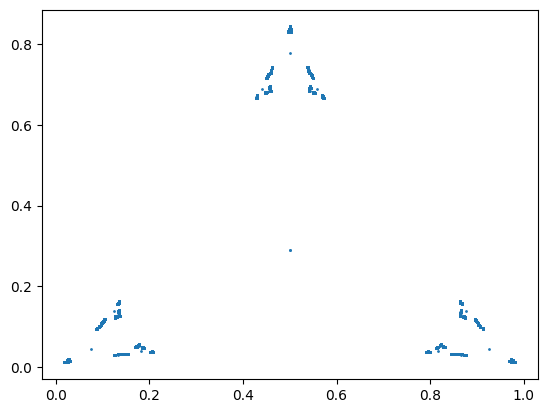

In [115]:
mess3 = Mess3(x=0.15, a=0.9)
msp = mess3.derive_mixed_state_tree(10)
paths, beliefs = msp.paths_and_belief_states
beliefs = np.array(beliefs)
beliefs = _project_to_simplex(beliefs)
plt.scatter(beliefs[0], beliefs[1], s=1)

Processing Paths: 100%|██████████| 29525/29525 [00:00<00:00, 49265.82it/s]


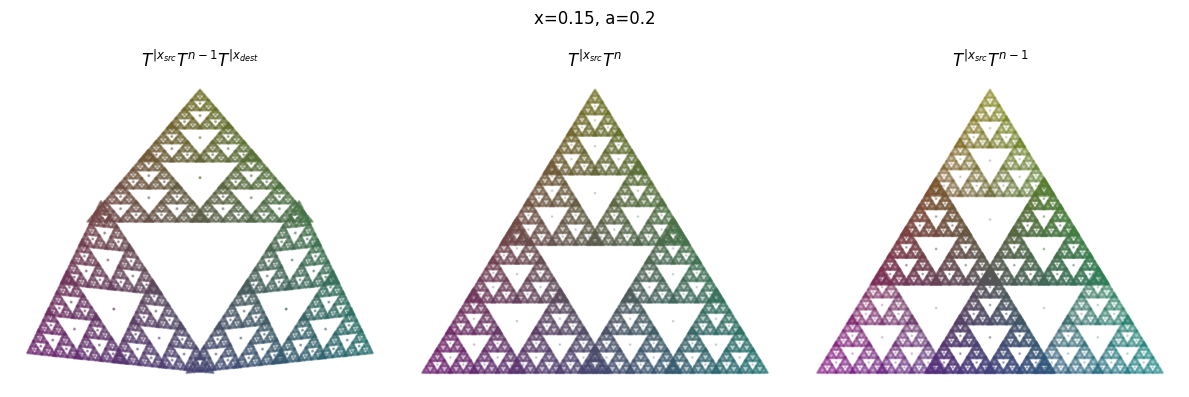

In [185]:
# pi T^{|xi} T^n
# pi T^{|xi} T^n-1
# pi T^{|xi} T^n-1 T^{|x0}
# pi T^{|xi} T^n-2 T^{|x0}

def compute_belief_vectors(x, a, depth, type='bigram', offset=0):
    p = Mess3(x=x, a=a)
    T = p.transition_matrix
    T_given_emission = T / T.sum(axis=2, keepdims=True)
    steady_state = p.steady_state_vector
    ss = steady_state

    msp = p.derive_mixed_state_tree(depth)
    paths, _ = msp.paths_and_belief_states

    # Pre-compute T_pow matrices for all possible depths
    max_depth = max(len(path) for path in paths)
    T_pow_cache = [np.linalg.matrix_power(T.sum(axis=0), i) for i in range(max_depth)]

    all_vecs = []

    for path in tqdm(paths, desc="Processing Paths", total=len(paths)):
        path_depth = len(path)
        if path_depth == 0 or path_depth > depth:
            continue
        
        end_symbol = path[-1]
        vec = np.zeros(3)
        for i, x in enumerate(reversed(path)):

            if i == 0:
                belief_update = np.einsum('i,ij->j', steady_state, T_given_emission[x])
                vec += belief_update
            else:
                if type == 'bigram':
                    belief_update = np.einsum('i,ij,jk->k', steady_state, T_given_emission[x], T_pow_cache[i-1+offset])
                    vec += belief_update - ss
                elif type == 'pairwise':
                    belief_update = np.einsum('i,ij,jk,kl->l', steady_state, T_given_emission[x], T_pow_cache[i-2+offset], T_given_emission[end_symbol])
                    vec += belief_update - np.einsum('i,ij->j', steady_state, T_given_emission[end_symbol])
               
        
        all_vecs.append(vec)

    all_vecs = np.array(all_vecs)
    all_vecs_proj = _project_to_simplex(all_vecs)

    return all_vecs, all_vecs_proj  # Convert to numpy array for better performance


x = 0.15
a = 0.2
all_vecs1, all_vecs1_proj = compute_belief_vectors(x=x, a=a, depth=9, type='pairwise', offset=1)
all_vecs2, all_vecs2_proj = compute_belief_vectors(x=x, a=a, depth=9, type='pairwise', offset=0)
all_vecs3, all_vecs3_proj = compute_belief_vectors(x=x, a=a, depth=9, type='bigram', offset=1)
all_vecs4, all_vecs4_proj = compute_belief_vectors(x=x, a=a, depth=9, type='bigram', offset=0)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

title2 = '$T^{|x_{src}} T^{n-1} T^{|x_{dest}}$'
title3 = '$T^{|x_{src}} T^{n}$'
title4 = '$T^{|x_{src}} T^{n-1}$'



for i, (vecs, vecs_proj, title) in enumerate([(all_vecs2, all_vecs2_proj, title2),
                                              (all_vecs3, all_vecs3_proj, title3),
                                              (all_vecs4, all_vecs4_proj, title4)]):
    axs[i].scatter(vecs_proj[0], -vecs_proj[1], s=1, alpha=0.2, c=vecs)
    axs[i].set_title(title)
    axs[i].axis('off')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    for spine in axs[i].spines.values():
        spine.set_visible(False)
fig.suptitle(f'x={x}, a={a}')
plt.tight_layout()


In [ ]:
p = Mess3(x=0.15, a=0.4)
T = p.transition_matrix
T_given_emission = T/T.sum(axis=2, keepdims=True)
steady_state = p.steady_state_vector

for depth in range(9):
    new_vec = np.linalg.matrix_power(T.sum(axis=0), depth) - p.steady_state_vector
    print(np.sqrt(np.sum(np.square(new_vec), axis=1))[0])

0.8164965809277259
0.4490731195102492
0.24699021573063698
0.1358446186518503
0.07471454025851756
0.04109299714218463
0.022601148428201455
0.012430631635510772
0.006836847399530888
